<a href="https://colab.research.google.com/github/binlee52/Individual-Research-1/blob/master/Script_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install pip==18.0

In [0]:
%%writefile setup.sh

git clone https://github.com/NVIDIA/apex
cd apex
pip install -v --no-cache-dir ./

In [0]:
!git clone https://github.com/NVIDIA/apex
!cd apex
!pip install -v --no-cache-dir apex

In [0]:
!sh setup.sh

In [0]:
pip install transformers==2.10.0

In [0]:
pip install simpletransformers

In [0]:
from transformers import *

In [0]:
import tensorflow as tf
import tensorflow_datasets
import pandas as pd

In [0]:
# Google drive 연결
from google.colab import drive
drive.mount('/content/drive')

# Load 
Load train set and evaluate set.

In [0]:
train_link = '/content/drive/My Drive/Colab Notebooks/tagged_script/tt0184858.csv'
train_df = pd.read_csv(train_link, dtype = {'sentence': str, 'label': int}) # type[0] must be str, type[1] must be int
train_df.columns = ['text', 'labels'] # [0] must be 'text', [1] must be 'labels'

In [13]:
train_df[:10]

,text,labels
0,"""REINDEER GAMES""",0
1,Screenplay by,0
2,Ehren Kruger,0
3,FADE IN:,0
4,FIGURE IN A SANTA CLAUS SUIT lies face-down in...,1
5,One of the body's red-sleeved arms is twisted ...,1
6,The white snow beneath the figure is spreading...,1
7,REVEAL EXT.,5
8,SNOWY ROAD,5
9,NIGHT,6


In [128]:
eval_link = '/content/drive/My Drive/Colab Notebooks/evaluate/eval_data.csv'
eval_df = pd.read_csv(eval_link, dtype = {'sentence': str, 'label': int})
eval_df.columns = ['text', 'labels']
eval_df[:10]

,text,labels
0,"In the darkness, we hear the solitary sound of...",1
1,NARRATOR,2
2,In between the years when the oceans drank Atl...,3
3,"Hither came Conan, the Cimmerian: a thief, a s...",3
4,"Muffled sounds, as if underwater, echo:",1
5,"CLANGING swords, the guttural CRIES of combat.",1
6,UNBORN BABY,2
7,"Eyes closed, floating at peace within red glow...",1
8,"Suddenly, a flash of steel, as a sword pierces...",1
9,"As the sword is ripped out, light streams in f...",1


# Create Model
Create classification model in simpletransformers with bert.

In [0]:
from simpletransformers.classification import ClassificationModel

In [0]:
checkpoint_path = '/content/drive/My Drive/2020년 1학기/개별연구/checkpoint/checkpoint-6120-epoch-10'
bestmodel_path = '/content/drive/My Drive/2020년 1학기/개별연구/best_model/'

In [0]:
params = {
          'num_train_epochs': 10,
          'reprocess_input_data': True,
          'overwrite_output_dir': True,
          'output_dir': checkpoint_path,
          'learning_rate':4e-5,
          'save_model_every_epoch': True,
          }

In [0]:
# Create New TransformerModel with modified attributes.
model = ClassificationModel('bert', 'bert-base-cased', num_labels=8, args=params)

In [0]:
# create model with save point if you have.
# learn if you make checkpoint before.
model = ClassificationModel('bert', checkpoint_path, num_labels=8, args=params)

# Train and Evaluate the model

In [0]:
# Train the model
model.train_model(train_df)

In [0]:
from sklearn.metrics import f1_score, accuracy_score

In [129]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df, acc=accuracy_score)
result

{'acc': 0.8595090209997043,
 'eval_loss': 1.2529028638884707,
 'mcc': 0.809918795278314}

# Show Confusion matrix

In [131]:
# get true/predict data value of labels.
predict_tag = model.predict(eval_df['text'])
predict_tag = predict_tag[0]
real_tag = eval_df['labels'].to_numpy()

In [0]:
# make confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(real_tag, predict_tag)

In [0]:
# function that show the confusion matrix
import numpy as np
import itertools

def plot_confusion_matrix(cm, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    plt.rcParams.update({'font.size': 12})
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)
    
    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:.1f}%".format(cm[i, j]*100),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",                         
                         color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:.3f}; misclass={:.3f}'.format(accuracy, misclass))
    plt.show()

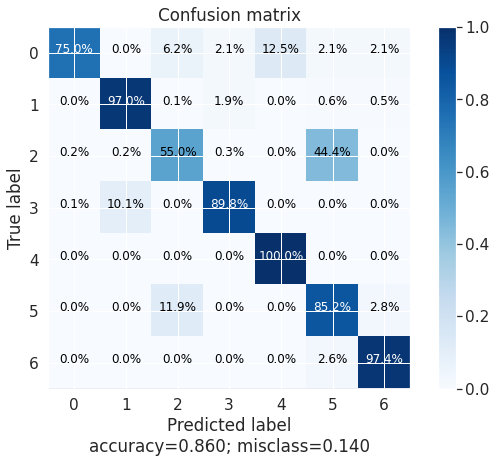

In [134]:
plot_confusion_matrix(cm)

# Example of a prediction

In [135]:
predictions, raw_outputs = model.predict(['JOHN'])
predictions, raw_outputs

(array([2]),
 array([[-3.2520697, -1.7112474,  6.8122797, -1.2658701, -6.3323083,
          3.3759193, -2.8762906, -6.284032 ]], dtype=float32))

In [136]:
predictions, raw_outputs = model.predict(['No thanks, I\'m not staying long.'])
predictions, raw_outputs

(array([3]),
 array([[-2.6874602, -1.1809847, -1.817727 , 10.946267 , -3.620548 ,
         -1.9809035, -2.0224838, -3.227146 ]], dtype=float32))

In [137]:
predictions, raw_outputs = model.predict(['FATHER GARRET and Angela have retreated to another area for privacy.'])
predictions, raw_outputs

(array([1]),
 array([[-2.1208348, 10.899748 , -2.3349154, -1.4440545, -3.46874  ,
         -1.9941462, -2.577853 , -3.3878212]], dtype=float32))

In [138]:
predictions, raw_outputs = model.predict(['ANGELA'])
predictions, raw_outputs

(array([2]),
 array([[-2.9858136, -2.9078133,  8.115907 , -1.0205463, -5.548365 ,
          1.7286791, -2.4328225, -5.530392 ]], dtype=float32))

In [139]:
predictions, raw_outputs = model.predict(['THEOLOGICAL SOCIETY'])
predictions, raw_outputs

(array([5]),
 array([[-1.5781777, -1.908352 , -0.7678223, -2.1011992, -3.8004048,
          9.245038 , -1.3364525, -3.3567183]], dtype=float32))

In [140]:
predictions, raw_outputs = model.predict(['FADE IN:'])
predictions, raw_outputs

(array([0]),
 array([[ 9.022472  , -1.0538936 , -0.708354  , -2.3187854 , -1.0444402 ,
         -0.584076  , -0.50222814, -0.79431903]], dtype=float32))

In [141]:
predictions, raw_outputs = model.predict(['FADE IN'])
predictions, raw_outputs

(array([5]),
 array([[-1.3846449 , -1.7646123 ,  0.08169459, -2.5190163 , -5.262247  ,
          8.844778  , -1.2443143 , -4.742187  ]], dtype=float32))

In [142]:
predictions, raw_outputs = model.predict(['LATER'])
predictions, raw_outputs

(array([6]),
 array([[-0.6201838, -1.7903019, -1.9980814, -1.6005195, -1.7697675,
         -1.0649323,  9.368775 , -1.55266  ]], dtype=float32))

In [143]:
predictions, raw_outputs = model.predict(['Our view RISES OVER him and gliding across the barren landscape are the SHADOW of WINGS.'])
predictions, raw_outputs

(array([1]),
 array([[-1.9985862, 10.899667 , -2.4050088, -1.6034287, -3.6152978,
         -1.7775816, -2.479868 , -3.4844263]], dtype=float32))

In [144]:
predictions, raw_outputs = model.predict(['MATCH CUT TO:'])
predictions, raw_outputs

(array([0]),
 array([[ 9.307918  , -1.631941  , -0.7078988 , -2.6796677 , -0.5734968 ,
         -0.59600127,  0.14466876,  0.09472334]], dtype=float32))

In [145]:
predictions, raw_outputs = model.predict(['That\'s called pain.'])
predictions, raw_outputs

(array([3]),
 array([[-2.6913226 , -0.45716253, -1.9313061 , 10.955523  , -3.879733  ,
         -2.076829  , -2.3474636 , -3.4002635 ]], dtype=float32))

In [147]:
predictions, raw_outputs = model.predict(['PALACE'])
predictions, raw_outputs

(array([5]),
 array([[-1.441915  , -2.496805  ,  0.01640904, -2.499284  , -4.6952963 ,
          8.936279  , -0.7734275 , -4.2198772 ]], dtype=float32))

In [148]:
predictions, raw_outputs = model.predict(['HARRY POTTER'])
predictions, raw_outputs

(array([2]),
 array([[-2.7345622, -2.906111 ,  6.981314 , -1.3936673, -6.340149 ,
          2.790843 , -1.6847022, -6.352914 ]], dtype=float32))

In [149]:
predictions, raw_outputs = model.predict(['Love means never having to say I\'m sorry.'])
predictions, raw_outputs

(array([3]),
 array([[-2.5556092, -1.0591936, -1.8752768, 10.956374 , -3.502167 ,
         -2.0816765, -2.0800986, -3.1308472]], dtype=float32))

In [151]:
predict_sentence = 'REVERSE ANGLE'
tagging_prediction, _ = model.predict([predict_sentence])
tagging_prediction

array([2])